# Lesson 4 Assignment - Automobile Price Hypothesis Testing
## Author - Kenji Oman

### Instructions
Test hypotheses for the price of automobiles:

1. Compare and test Normality the distributions of **price** and **log price** <br/>
Use both a graphical method and a formal test. Hint: Remember these relationships will always be approximate.

2. Test significance of **price (or log price)** stratified by 
a) **fuel type**, b) **aspiration**, and c) **rear vs. front wheel drive**. <br />Use both graphical methods and the formal test.

3. Apply ANOVA and Tukey's HSD test to the auto price data to compare the **price (or log price** if closer to a Normal distribution) of autos stratified by **body style**.

4. Graphically explore the differences between the price conditioned by the categories of each variable <br/>
Hint: Make sure you have enough data for each category and drop categories with insufficient data.

5. Use standard ANOVA and Tukey HSD to test the differences of these groups.


#### Note: 
Please clearly outline the results of these tests with markdown text. Be sure your discussion includes narrative for your figures and tables so it is clear to the reader the importance of each bit of evidence.

In [ ]:
# Cleaned up Dataset location
fileName = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/Automobile%20price%20data%20_Raw_.csv"

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

%matplotlib inline

/home/koman/miniconda3/envs/dsc/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# Set the seed, to make things reproducable
np.random.seed(0)

# Load and Peak at Data

In [4]:
# Import Data, specifying that '?' is a null value
df = pd.read_csv(fileName, na_values='?')

# rename column names to replace '-' characters with '_'
# to make it easier to call the columns later
df.columns = [x.replace('-', '_') for x in df.columns]

df.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


In [5]:
display(df.info())
df.isnull().any()[df.isnull().any()]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
symboling            205 non-null int64
normalized_losses    164 non-null float64
make                 205 non-null object
fuel_type            205 non-null object
aspiration           205 non-null object
num_of_doors         203 non-null object
body_style           205 non-null object
drive_wheels         205 non-null object
engine_location      205 non-null object
wheel_base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb_weight          205 non-null int64
engine_type          205 non-null object
num_of_cylinders     205 non-null object
engine_size          205 non-null int64
fuel_system          205 non-null object
bore                 201 non-null float64
stroke               201 non-null float64
compression_ratio    205 non-null float64
horsepower           203 non-

None

normalized_losses    True
num_of_doors         True
bore                 True
stroke               True
horsepower           True
peak_rpm             True
price                True
dtype: bool

In [6]:
df.loc[df.isnull().any(axis=1) & ~df.normalized_losses.isnull(),
       'normalized_losses num_of_doors bore stroke horsepower peak_rpm price'.split()]

,normalized_losses,num_of_doors,bore,stroke,horsepower,peak_rpm,price
27,148.0,NaN,3.03,3.39,102.0,5500.0,8558.0
55,150.0,two,NaN,NaN,101.0,6000.0,10945.0
56,150.0,two,NaN,NaN,101.0,6000.0,11845.0
57,150.0,two,NaN,NaN,101.0,6000.0,13645.0
58,150.0,two,NaN,NaN,135.0,6000.0,15645.0


From the above, it looks like `normalized_losses`, `num_of_doors`, `bore`, `stroke`, `horsepower`, `peak_rpm`, and `price` all contain NA values. Also, `normalized_losses` has the vast majority of null values, with only 5 rows not having NA in `normalized_losses`, with NA in a different column.  For now, let's leave these rows, and just drop the NA values as needed.

Also, it looks like we don't have a log_price column, so let's make one

In [7]:
# Make log_price, so we can use it for the assignment
df['log_price'] = df.price.apply(np.log)
df.log_price.head()

0    9.510075
1    9.711116
2    9.711116
3    9.543235
4    9.767095
Name: log_price, dtype: float64

# Normality Check

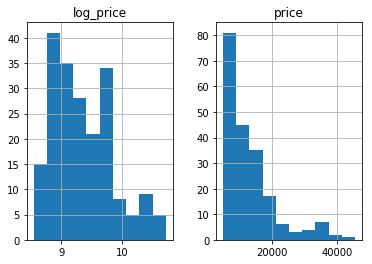

In [8]:
# Let's look at the histograms of price and log_price to see if they
# "look" normal
df[['price', 'log_price']].hist()
plt.show()

The log_price definitely looks more normal. Let's look at a Q-Q plot to see how it compares with this type of plot.

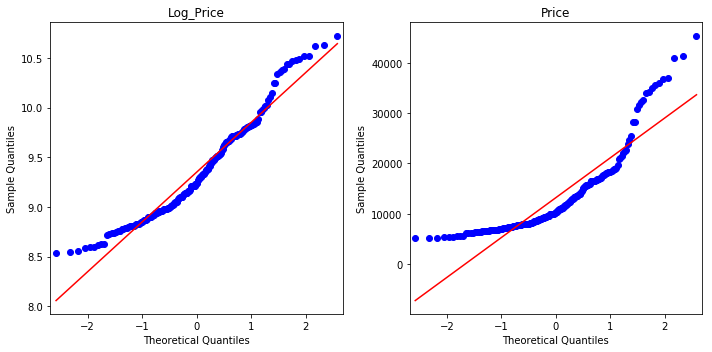

In [9]:
# Set up figure, and make Q-Q plot
f = plt.figure(figsize=(10,5))
ax = f.add_subplot(121)
sm.qqplot(df.log_price.dropna(), line='s', ax=ax)
ax.set_title('Log_Price')
ax = f.add_subplot(122)
sm.qqplot(df.price.dropna(), line='s', ax=ax)
ax.set_title('Price')
f.tight_layout()
plt.show()

Here once again, we see that the log_price is more normal, but would need to be a bit "fatter"/ spread out to truly be a normal distribution.  Now, let's finish this up by doing a Kolmogorov-Smirnov test.

In [10]:
# Check if this distribution is the same as a normal one, if the normal
# distribution has the same mean and sd as the data
print("Log Price:", stats.ks_2samp(df.log_price.dropna(),
                       stats.norm.rvs(df.log_price.mean(), df.log_price.std(), size=df.log_price.dropna().shape[0])))
print("Price:", stats.ks_2samp(df.price.dropna(),
                       stats.norm.rvs(df.price.mean(), df.price.std(), size=df.price.dropna().shape[0])))

Log Price: Ks_2sampResult(statistic=0.0995024875621891, pvalue=0.2588708799414671)
Price: Ks_2sampResult(statistic=0.1791044776119403, pvalue=0.0026739729921134558)


So, we see that, at the 95% confidence level ($\alpha = 0.05$), we cannot reject the null hypothesis that the log_price is different from a normal distribution, but we do reject the null hypothesis for the price.  Moving forward, since the log_price is more normal, let's use it.

In [11]:
# Before we do anything else, let's drop rows where log_price is NA
clean_df = df[~df.log_price.isnull()]

# Stratified Log Price 2-sample Significance Tests
## Stratified by fuel type

In [12]:
# First, look at the unique values of fuel_type
clean_df.fuel_type.unique()

array(['gas', 'diesel'], dtype=object)

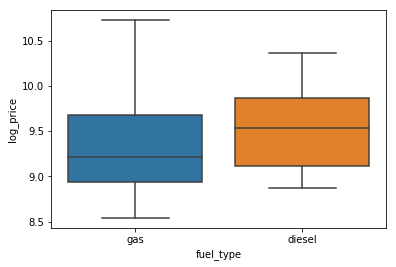

In [13]:
# There are only two items, so let's compare the log_price distributions
# for these two fuel_types
sns.boxplot(x='fuel_type', y='log_price', data=clean_df)
plt.show()

Looks like diesel vehicles with diesel engines are more expensive overall, but let's do an actual test.

In [14]:
# Do a 2-sample t-test, and don't assume equal variance, since it isn't necessarily
# true
stats.ttest_ind(clean_df[clean_df.fuel_type == 'gas'].log_price,
                clean_df[clean_df.fuel_type == 'diesel'].log_price, equal_var=False)

Ttest_indResult(statistic=-1.9970831113766496, pvalue=0.05745968103494916)

So, we see that if we stratify by fuel type (gas vs diesel), at the 95% significance level, we **do not** see that there is any difference between the logarithm of the price for the two groups.

## Stratified by aspiration

In [15]:
# First, look at the unique values of aspiration
clean_df.aspiration.unique()

array(['std', 'turbo'], dtype=object)

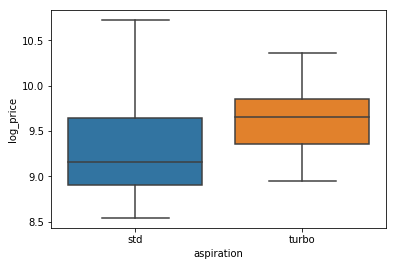

In [16]:
# There are only two items, so let's compare the log_price distributions
# for these two aspirations
sns.boxplot(x='aspiration', y='log_price', data=clean_df)
plt.show()

Looks like turbo vehicles are more expensive overall, but let's do an actual test.

In [17]:
# Do a 2-sample t-test, and don't assume equal variance, since it isn't necessarily
# true
stats.ttest_ind(clean_df[clean_df.aspiration == 'std'].log_price,
                clean_df[clean_df.aspiration == 'turbo'].log_price, equal_var=False)

Ttest_indResult(statistic=-4.477688160472093, pvalue=3.136739956393653e-05)

Wow, these are really significantly different!

## Stratified by Rear vs Front-wheel drive

In [18]:
# First, look at the unique values of drive wheels
clean_df.drive_wheels.unique()

array(['rwd', 'fwd', '4wd'], dtype=object)

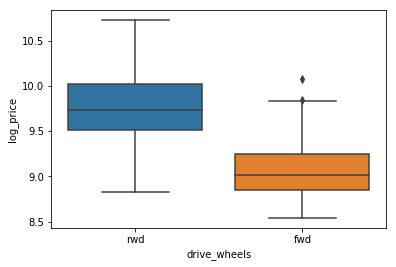

In [19]:
# There are three items, but we were asked to only compare
# rear vs front wheel drive vehicles. So, let's see how the
# log prices compare
sns.boxplot(x='drive_wheels', y='log_price', data=clean_df[clean_df.drive_wheels.isin(['rwd', 'fwd'])])
plt.show()

Wow, even graphically these look very different!  Let's do an actual test:

In [20]:
# Do a 2-sample t-test, and don't assume equal variance, since it isn't necessarily
# true
stats.ttest_ind(clean_df[clean_df.drive_wheels == 'rwd'].log_price,
                clean_df[clean_df.drive_wheels == 'fwd'].log_price, equal_var=False)

Ttest_indResult(statistic=12.273400903774084, pvalue=3.964887459358143e-23)

As expected, very significantly different!

# Log Price Stratified by Body Style

In [21]:
# First, let's look at the number of different body styles
clean_df.body_style.unique()

array(['convertible', 'hatchback', 'sedan', 'wagon', 'hardtop'],
      dtype=object)

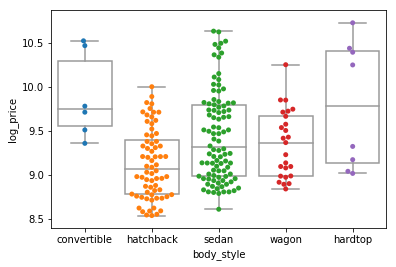

In [22]:
# So, we have 5 body styles.  Let's look at how log_price compares when
# stratified by these
ax = sns.boxplot(x='body_style', y='log_price', data=clean_df, color='white')
sns.swarmplot(x='body_style', y='log_price', data=clean_df, ax=ax)
plt.show()

In [23]:
# We see that we really don't have much data for convertibles
# and hardtop cars, so let's not include them in our analysis.
# First, let's restructure our data to give us one column each for
# the body types we are interested in
temp = clean_df.loc[~clean_df.body_style.isin(['convertible', 'hardtop'])].pivot(columns='body_style',
                                                                                 values='log_price')
display(temp.head())
temp_columns = temp.columns.tolist()

body_style,hatchback,sedan,wagon
2,9.711116,NaN,NaN
3,NaN,9.543235,NaN
4,NaN,9.767095,NaN
5,NaN,9.632335,NaN
6,NaN,9.781885,NaN


In [24]:
# We want a list of the values, dropping the NAs that were created as a
# result of keeping the original index (this way, we can
# unpack each column for use in our comparisons later)
temp = [temp[x].dropna().values for x in temp.columns]
[x[:5] for x in temp]

[array([9.71111566, 8.54694615, 8.74751095, 8.62550933, 8.76045305]),
 array([ 9.54323479,  9.76709493,  9.63233478,  9.78188473, 10.08058717]),
 array([ 9.84797484,  9.09616333,  8.89494446, 10.24877794,  8.90231953])]

In [25]:
# Now, let's do ANOVA to check if each of the log_price distributions
# is the same for hatchback, sedan, and wagons (although, just looking
# at the plot above, it doesn't seem to be the case ...)
stats.f_oneway(*temp)

F_onewayResult(statistic=9.274406034602693, pvalue=0.00014538087468160497)

So, we see that, at the 95% confidence level, at least one sample that has a different mean log_price than the others.  Let's use Tukey's HSD method to see which one(s) is different.

In [26]:
# First, let's make the data as one list, and groupings as one list
data = [y for x in temp for y in x]
display((data[:3], data[-3:]))
# For the groups
groups = [[temp_columns[x]]*temp[x].shape[0] for x in range(3)]
groups = [y for x in groups for y in x]
groups[:3], groups[-3:]

([9.711115659888671, 8.546946149565585, 8.747510946478448],
 [9.504128762859725, 9.71202433782489, 9.849559210510572])

(['hatchback', 'hatchback', 'hatchback'], ['wagon', 'wagon', 'wagon'])

In [27]:
# Now, for the test
results = sm.stats.multicomp.pairwise_tukeyhsd(data, groups)
print(results)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
  group1  group2 meandiff  lower  upper  reject
-----------------------------------------------
hatchback sedan   0.3109   0.1394 0.4823  True 
hatchback wagon   0.2229   -0.029 0.4748 False 
  sedan   wagon   -0.088  -0.3303 0.1544 False 
-----------------------------------------------


So, we see that the log_price for hatcback cars is significantly different than for sedans, while the other two comparisons are not different.  Interesting, since if we remember or boxplots/ swarmplots from before:

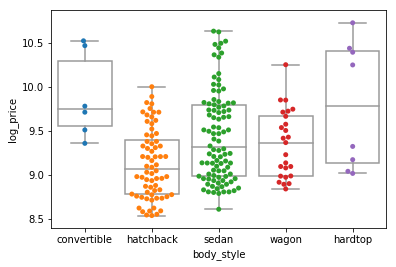

In [28]:
# Boxplot/swarmplots for log_price stratified by body_style, from before
ax = sns.boxplot(x='body_style', y='log_price', data=clean_df, color='white')
sns.swarmplot(x='body_style', y='log_price', data=clean_df, ax=ax)
plt.show()

I would have thought wagons were significantly more expensive than hatchbacks as well, with no difference between sedans and wagons.  But, this shows why we should rely on statistical tests and not just "by-eye" comparisons.